In [1]:
from splinter import Browser
from bs4 import BeautifulSoup
import requests
import re
import time
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import networkx as nx

# google scholar navigation

In [6]:
executable_path = {'executable_path':r'C:\Windows\chromedriver.exe'}

In [13]:
def scrape(name):
#     with Browser('chrome', **executable_path) as browser:
        # Visit URL
        browser = Browser(driver_name='chrome', headless=False) #headless=False will show the browser navigation
        url = "https://scholar.google.com.br/"
        browser.visit(url)
        browser.fill('q', name)

        # Find and click the 'search' button
        button = browser.find_by_name('btnG')
        time.sleep(1) # needs to sleep for the button to become active
        button.click()

        # Find and click the first link
        button = browser.find_link_by_partial_href('citations?user=')
        time.sleep(1)
        button.click()

        #expand the page
        button = browser.find_by_id('gsc_bpf_more')    
        check_button = browser.evaluate_script('document.getElementById("gsc_bpf_more").disabled')
        while check_button == False:
            time.sleep(1)
            check_button = browser.evaluate_script('document.getElementById("gsc_bpf_more").disabled')
            button.click()

        #get html
        return browser.html

In [19]:
author_name = 'Jeffrey Heer'
result = scrape(author_name)

In [20]:
soup = BeautifulSoup(result, 'html.parser')

In [21]:
papers = []
table = soup.find("table", id="gsc_a_t") 
for tr in table.find_all('tr')[2:]:
    for td in tr.find_all("td", {"class": "gsc_a_t"}):
        paper = {}
        paper['title'] = tr.find("a", {"class": "gsc_a_at"}).get_text()
        authors = tr.find("div", {"class": "gs_gray"}).get_text().split(',')[:5]
        authors = [a.strip() for a in authors]
        paper['authors'] = authors
        papers.append(paper)

In [22]:
papers[0]

{'title': 'D3: Data-Driven Documents',
 'authors': ['M Bostock', 'V Ogievetsky', 'J Heer']}

# part 2

### authors

In [23]:
author_paper = pd.DataFrame(papers, columns=['title', 'authors'])

In [24]:
author_paper.tail()

,title,authors
229,matthewt@ seattleu. edu,"[S Waterson, JI Hong, T Sohn, J Heer, T Matthews]"
230,SPECIAL ISSUE DOES BINDING OF SYNESTHETIC COLO...,"[N Sagiv, J Heer, L Robertson]"
231,Evaluating Visualizations to Unearth Behavior ...,[J Heer]
232,VisWeek conference committee,"[M Haley, T Gallemore, M Kingman, D Zemek, E B..."
233,The Changing Dynamics of Scientific Collaborat...,"[CR Aragon, J Heer, C Lee, C Silva]"


In [25]:
len(author_paper)

234

In [26]:
authors_table = author_paper.authors.apply(pd.Series).stack(dropna=True).reset_index(drop=True)
authors_table = pd.DataFrame(authors_table)[0].apply(lambda x: x.strip()).unique()
authors_table = pd.DataFrame(authors_table, columns=['author'])
authors_table = authors_table.sort_values('author')

In [27]:
authors_table = authors_table.reset_index().drop('index', axis=1)
authors_table.tail()

,author
276,YS Kim
277,Z Liu
278,Z Qu
279,Ç Demiralp
280,ÇDCE Scheidegger


### papers

In [28]:
papers_table = author_paper['title']

### SQL

In [29]:
sql_db = 'hw1.sqlite'
conn = sqlite3.connect(sql_db)
cur = conn.cursor()

In [30]:
def build_sql_table(dataframe, table_name):   
    try: 
        dataframe.to_sql(table_name, conn, index_label = "id")
    except Exception as error:
        print("\033[91m", error)
        error = str(error)
        if 'already exists' in error:
            user_input = input("Table already exists. Continue? Type 'yes' or 'no' on your keyboard: ")
            if user_input == 'yes': 
                dataframe.to_sql(table_name, conn, index_label = "id", if_exists="replace")
                print('Table',table_name, 'was created on database', sql_db)
            else:
                print('Table was not created')
        pass

In [31]:
build_sql_table(authors_table, 'authors')

 Table 'authors' already exists.
Table already exists. Continue? Type 'yes' or 'no' on your keyboard: yes
Table authors was created on database hw1.sqlite


In [32]:
build_sql_table(papers_table, 'papers')

 Table 'papers' already exists.
Table already exists. Continue? Type 'yes' or 'no' on your keyboard: yes
Table papers was created on database hw1.sqlite


In [33]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
cur.fetchall()  

[('author_paper',), ('authors',), ('papers',)]

### author_paper

In [34]:
author_paper_table = author_paper.authors.apply(pd.Series) \
    .merge(author_paper, left_index = True, right_index = True) \
    .drop(["authors"], axis = 1) \
    .melt(id_vars = ['title'], value_name = "author") \
    .drop("variable", axis = 1) \
    .dropna()

In [35]:
#remove espaçamento nos nomes
author_paper_table = pd.DataFrame(author_paper_table.author.apply(lambda x: x.strip())) \
    .merge(author_paper_table[['title']], left_index = True, right_index = True)

In [36]:
author_paper_table.tail()

,author,title
1157,JJ van Wijk,Symposium Committee
1160,G Chaudhary,VIS Conference Committee
1162,J Kennedy,VIS Conference Committee
1165,T Matthews,matthewt@ seattleu. edu
1168,E Bertini,VisWeek conference committee


In [37]:
author_paper_table.shape

(741, 2)

In [38]:
cur.execute('''CREATE TABLE IF NOT EXISTS author_paper 
               (title_id INT, author_id INT)
               ;''')

In [39]:
for index, row in author_paper_table.iterrows():
    title = row[1]
    author = row[0]
    
    #print(row[1])
    #print(row[0])
    
    query = 'SELECT id FROM papers WHERE title = "{}"'.format(title)
    cur.execute(query)
    title_id = cur.fetchone()[0]
    query = 'SELECT id FROM authors WHERE author = "{}"'.format(author)
    #print(query)
    cur.execute(query)
    author_id = cur.fetchone()[0]
    
    #print(title_id, author_id)
    query = "INSERT INTO author_paper VALUES ({}, {})".format(title_id,author_id)
    cur.execute(query)
    conn.commit()

# networks

# build networks

### authors

In [40]:
G=nx.Graph()

In [41]:
authors = pd.read_sql_query('SELECT * FROM authors',conn)

In [42]:
labels={}
for index,row in authors.iterrows():
    G.add_node(row[0])
    labels[row[0]]=row[1]

In [43]:
author_paper = pd.read_sql_query('SELECT * FROM author_paper',conn)
author_paper = author_paper.sort_values(by='title_id')

In [44]:
author_paper.head()

,title_id,author_id
0,0,157
427,0,117
715,0,165
1159,0,122
949,0,264


In [45]:
graph = list(author_paper.groupby(['title_id'])['author_id'].apply(list))
graph[:5]

[[157, 117, 165, 122, 264, 254],
 [243, 237, 117, 132, 122, 136],
 [53, 52, 117, 122],
 [81, 81, 117, 122],
 [122, 117, 157, 165]]

In [46]:
for group in graph:
    if len(group)<2: continue
    for i in range(0,len(group)-1):
        for j in range(i+1,len(group)):
            G.add_edge(group[i],group[j])

In [47]:
pos=nx.spring_layout(G, k=0.2, weight=1, iterations=50)

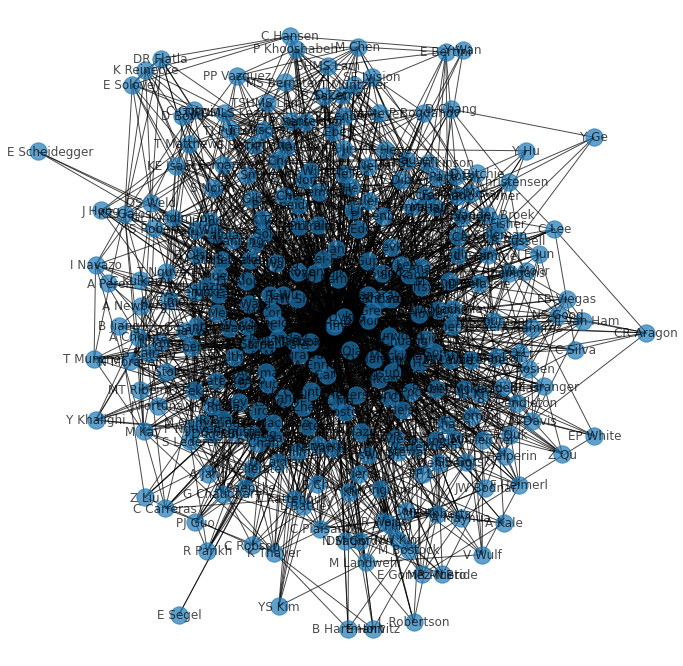

In [48]:
plt.figure(3,figsize=(12,12)) 
nx.draw_networkx(G, pos, labels=labels, alpha=0.7)
plt.axis('off')
#plt.show()
plt.savefig("authors_graph.png")

### papers

In [49]:
G_papers=nx.Graph()

In [50]:
papers = pd.read_sql_query('SELECT * FROM papers',conn)

In [51]:
labels={}
for index,row in papers.iterrows():
    G_papers.add_node(row[0])
    labels[row[0]]=row[1]

In [52]:
author_paper = pd.read_sql_query('SELECT * FROM author_paper',conn)
author_paper = author_paper.sort_values(by='author_id')

In [53]:
author_paper.head()

,title_id,author_id
438,20,0
490,90,0
705,185,0
1070,129,0
407,200,1


In [54]:
graph = list(author_paper.groupby(['author_id'])['title_id'].apply(list))
graph[:5]

[[20, 90, 185, 129],
 [200, 139, 152, 20, 196, 92],
 [211, 34, 144, 146],
 [30, 46],
 [93, 159, 99, 149]]

In [55]:
for group in graph:
    if len(group)<2: continue
    for i in range(0,len(group)-1):
        for j in range(i+1,len(group)):
            G_papers.add_edge(group[i],group[j])

In [56]:
pos=nx.spring_layout(G_papers, k=0.2, weight=1, iterations=50)

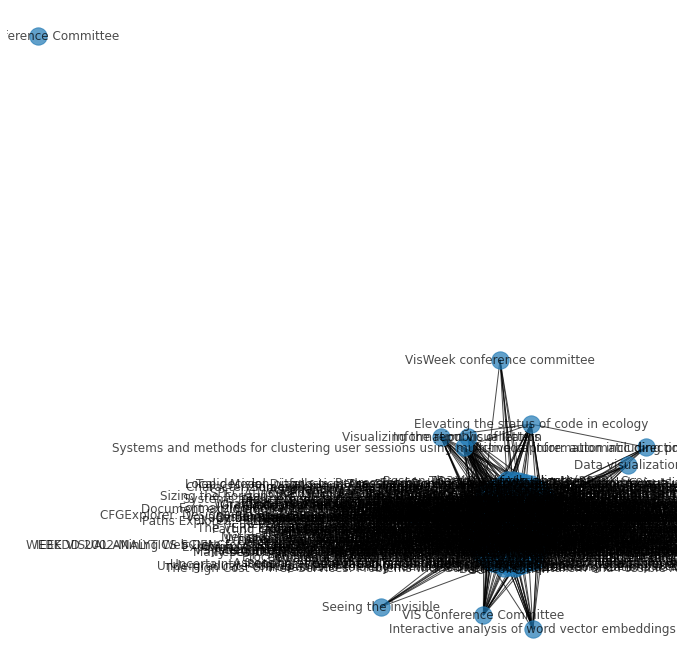

In [57]:
plt.figure(3,figsize=(12,12)) 
nx.draw_networkx(G_papers, pos, labels=labels, alpha=0.7)
plt.axis('off')
plt.savefig("papers_graph.png")

# drafts

In [9]:
#class DataScraper:
#    def __init__(self):
#        pass

# retrieve data with splinter

In [2]:
req = requests.get("https://www.google.com/")
page = req.text

In [72]:
req = requests.get("https://scholar.google.com.br/citations?user=vlgs4G4AAAAJ&hl=pt-BR&oi=ao")
page = req.text

In [73]:
soup = BeautifulSoup(page, 'html.parser')
print (soup.prettify())

<!DOCTYPE doctype html>
<html>
 <head>
  <title>
   Jeffrey Heer - Citações do Google Acadêmico
  </title>
  <meta content="text/html;charset=utf-8" http-equiv="Content-Type"/>
  <meta content="IE=Edge" http-equiv="X-UA-Compatible"/>
  <meta content="always" name="referrer"/>
  <meta content="width=device-width,initial-scale=1,minimum-scale=1,maximum-scale=2" name="viewport"/>
  <meta content="telephone=no" name="format-detection"/>
  <link href="/favicon.ico" rel="shortcut icon"/>
  <link href="http://scholar.google.com/citations?user=vlgs4G4AAAAJ&amp;hl=en" rel="canonical"/>
  <style>
   html,body,form,table,div,h1,h2,h3,h4,h5,h6,img,ol,ul,li,button{margin:0;padding:0;border:0;}table{border-collapse:collapse;border-width:0;empty-cells:show;}html,body{height:100%}#gs_top{position:relative;box-sizing:border-box;min-height:100%;min-width:964px;-webkit-tap-highlight-color:rgba(0,0,0,0);}#gs_top>*:not(#x){-webkit-tap-highlight-color:rgba(204,204,204,.5);}.gs_el_ph #gs_top,.gs_el_ta #gs_to

In [51]:
with Browser('chrome', **executable_path) as browser:
    # Visit URL
    url = "http://www.google.com"
    browser.visit(url)
    browser.fill('q', 'splinter - python acceptance testing for web applications')
    # Find and click the 'search' button
    button = browser.find_by_name('btnK')
    print(button)
    # Interact with elements
    time.sleep(5) # needs to sleep for the button to become active
    button.click()
    if browser.is_text_present('splinter.readthedocs.io'):
        print("Yes, the official website was found!")
    else:
        print("No, it wasn't found... We need to improve our SEO techniques")

Yes, the official website was found!


### testing webdriver
* https://sites.google.com/a/chromium.org/chromedriver/getting-started

In [26]:
from selenium import webdriver

driver = webdriver.Chrome("C:\Windows\chromedriver.exe")  # Optional argument, if not specified will search path.
driver.get('http://www.google.com/xhtml');
time.sleep(5) # Let the user actually see something!
search_box = driver.find_element_by_name('q')
search_box.send_keys('ChromeDriver')
search_box.submit()
time.sleep(5) # Let the user actually see something!
driver.quit()

In [ ]:
result = result.split('\n')

In [ ]:
re.findall('^\d+ ?\d+$', '2006')

In [157]:
for element in result:
    if element == '*':
        result.remove(element)
    elif len(re.findall('^\d+ ?\d+$', element)) is not 0:
        print(element)
        result.remove(element)

In [173]:
count = 0
papers = []
for element in result[:50]: #must fix extraction
    if count%3 == 0:
        paper = {}
        paper['title'] = element
    if count%3 == 1:
        paper['authors'] = element.split(',')[:5]
        papers.append(paper)
    count += 1

In [161]:
test = '322 2008'
re.findall('^\d+ ?\d+$', test)

['322 2008']

In [378]:
import os

In [380]:
os.getcwd()

'D:\\Dropbox\\A-Marcelo\\education-work\\2017-EMAP\\14-ds\\homeworks\\FDS-Homeworks\\hw1'